In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0-rc1


## 案例1、 keras版本模型训练
相关函数
- 构建模型（顺序模型、函数式模型、子类模型）
- 模型训练：model.fit()
- 模型验证：model.evaluate()
- 模型预测： model.predict()

### 1.1 构建模型

In [2]:
inputs = tf.keras.Input(shape=(32,))  #(batch_size=32,数据维度32)
x = tf.keras.layers.Dense(64, activation='relu')(inputs) #（64个神经元，）
x = tf.keras.layers.Dense(64, activation='relu')(x)#（63个神经元）
predictions = tf.keras.layers.Dense(10)(x) #（输出是10类）

In [3]:
#- inputs(模型输入)
#- output(模型输出)

model = tf.keras.Model(inputs=inputs, outputs=predictions)

#指定损失函数 (loss) tf.keras.optimizers.RMSprop
#优化器 (optimizer) tf.keras.losses.SparseCategoricalCrossentropy
#指标 (metrics) ['accuracy'] 

model.compile(optimizer=tf.keras.optimizers.Adam(0.001), #优化器
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #损失函数
              metrics=['accuracy']) #评估函数


提供[许多内置的优化器，损失和指标](https://www.tensorflow.org/guide/keras/train_and_evaluate#many_built-in_optimizers_losses_and_metrics_are_available)
通常，不必从头开始创建自己的损失，指标或优化函数，因为所需的可能已经是Keras API的一部分：

优化器：
- SGD() （有或没有动量）
- RMSprop()
- Adam()

损失：
- MeanSquaredError()
- KLDivergence()
- CosineSimilarity()

指标：
- AUC()
- Precision()
- Recall()


另外，如果想用上述的默认设置，那么在很多情况下，可以通过字符串标识符指定优化器，损失和指标：

In [4]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [7]:
###构建数据集
#
import numpy as np
x_train = np.random.random((1000, 32))
y_train = np.random.randint(10, size=(1000, ))

x_val = np.random.random((200, 32))
y_val = np.random.randint(10, size=(200, ))

x_test = np.random.random((200, 32))
y_test = np.random.randint(10, size=(200, ))


### 1.2 模型训练

通过将数据切成大小为“ batch_size”的“批”来训练模型，并针对给定数量的“epoch”重复遍历整个数据集

In [ ]:
# help(model.fit)
#N/batch_size = 10

In [9]:
model.fit(x_train, y_train, batch_size=32, epochs=5, validation_data=  (x_val, y_val)     )

Train on 1000 samples, validate on 200 samples
Epoch 1/5
1000/1000 [==============================] - 0s 188us/sample - loss: 2.3188 - accuracy: 0.1040 - val_loss: 2.3260 - val_accuracy: 0.0900
Epoch 2/5
1000/1000 [==============================] - 0s 160us/sample - loss: 2.2992 - accuracy: 0.1350 - val_loss: 2.3271 - val_accuracy: 0.1150
Epoch 3/5
1000/1000 [==============================] - 0s 154us/sample - loss: 2.2862 - accuracy: 0.1310 - val_loss: 2.3296 - val_accuracy: 0.0850
Epoch 4/5
1000/1000 [==============================] - 0s 169us/sample - loss: 2.2748 - accuracy: 0.1410 - val_loss: 2.3303 - val_accuracy: 0.1000
Epoch 5/5
1000/1000 [==============================] - 0s 163us/sample - loss: 2.2661 - accuracy: 0.1660 - val_loss: 2.3346 - val_accuracy: 0.0650


自动划分验证集

在前面的例子中，我们使用validation_data参数将Numpy数组的元组传递(x_val, y_val)给模型，以在每个时期结束时评估验证损失和验证指标。

还有一个选择：参数validation_split允许您自动保留部分训练数据以供验证。参数值代表要保留用于验证的数据的一部分，因此应将其设置为大于0且小于1的数字。例如，validation_split=0.2表示“使用20％的数据进行验证”，而validation_split=0.6表示“使用60％的数据用于验证”。

验证的计算方法是在进行任何改组之前，对fit调用接收到的数组进行最后x％的采样。

注意，只能validation_split在使用Numpy数据进行训练时使用。

In [13]:
model.fit(x_train, y_train, batch_size=64, validation_split=0.2, epochs=1)

Train on 800 samples, validate on 200 samples
800/800 [==============================] - 0s 100us/sample - loss: 2.2449 - accuracy: 0.1787 - val_loss: 2.2530 - val_accuracy: 0.2050


### 1.3 模型验证

返回 test loss 和metrics

In [14]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(x_test, y_test, batch_size=128)
print('test loss, test acc:', results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions for 3 samples')
predictions = model.predict(x_test[:3])
print('predictions shape:', predictions.shape)


# Evaluate on test data
200/1 [========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

## 案例2、使用样本加权和类别加权

除了输入数据和目标数据外，还可以在使用时将样本权重或类权重传递给模型fit：

从Numpy数据进行训练时：通过sample_weight和class_weight参数。
从数据集训练时：通过使数据集返回一个元组(input_batch, target_batch, sample_weight_batch)。
“样本权重”数组是一个数字数组，用于指定批次中每个样本在计算总损失时应具有的权重。它通常用于不平衡的分类问题中（这种想法是为很少见的班级赋予更多的权重）。当所使用的权重为1和0时，该数组可用作损失函数的掩码（完全丢弃某些样本对总损失的贡献）。

“类别权重”字典是同一概念的一个更具体的实例：它将类别索引映射到应该用于属于该类别的样本的样本权重。例如，如果在数据中类“ 0”的表示量比类“ 1”的表示量少两倍，则可以使用class_weight={0: 1., 1: 0.5}。

这是一个Numpy示例，其中我们使用类权重或样本权重来更加**重视第5类的正确分类**。

## 2.1 构建模型

In [16]:
def get_uncompiled_model():
    inputs = tf.keras.Input(shape=(32,), name='digits')
    x = tf.keras.layers.Dense(64, activation='relu', name='dense_1')(inputs)
    x = tf.keras.layers.Dense(64, activation='relu', name='dense_2')(x)
    outputs = tf.keras.layers.Dense(10, name='predictions')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_compiled_model():
    model = get_uncompiled_model()
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['sparse_categorical_accuracy'])
    return model


## 2.2 模型训练

模型加权

In [17]:
import numpy as np

#类别5：加权
class_weight = {0: 1., 1: 1., 2: 1., 3: 1., 4: 1.,
                5: 2.,
                6: 1., 7: 1., 8: 1., 9: 1.}


print('Fit with class weight')
model = get_compiled_model()
model.fit(x_train, y_train,
          class_weight=class_weight,
          batch_size=64,
          epochs=4)

Fit with class weight
Train on 1000 samples
Epoch 1/4
1000/1000 [==============================] - 1s 826us/sample - loss: 2.5088 - sparse_categorical_accuracy: 0.0800
Epoch 2/4
1000/1000 [==============================] - 0s 78us/sample - loss: 2.4838 - sparse_categorical_accuracy: 0.0850
Epoch 3/4
1000/1000 [==============================] - 0s 76us/sample - loss: 2.4749 - sparse_categorical_accuracy: 0.0870
Epoch 4/4
1000/1000 [==============================] - 0s 75us/sample - loss: 2.4648 - sparse_categorical_accuracy: 0.0900


样本加权

In [18]:
# Here's the same example using `sample_weight` instead:
sample_weight = np.ones(shape=(len(y_train),))

sample_weight[y_train == 5] = 2.
print('\nFit with sample weight')




Fit with sample weight


In [ ]:
sample_weight

In [20]:
model = get_compiled_model()
model.fit(x_train, y_train,
          sample_weight=sample_weight,
          batch_size=64,
          epochs=4)

Train on 1000 samples
Epoch 1/4
1000/1000 [==============================] - 1s 901us/sample - loss: 2.5171 - sparse_categorical_accuracy: 0.0820
Epoch 2/4
1000/1000 [==============================] - 0s 80us/sample - loss: 2.4877 - sparse_categorical_accuracy: 0.0860
Epoch 3/4
1000/1000 [==============================] - 0s 70us/sample - loss: 2.4804 - sparse_categorical_accuracy: 0.0860
Epoch 4/4
1000/1000 [==============================] - 0s 83us/sample - loss: 2.4733 - sparse_categorical_accuracy: 0.0880


## 案例3、使用回调函数

Keras中的回调是在训练期间（在某个时期开始时，在批处理结束时，在某个时期结束时等）在不同时间点调用的对象，这些对象可用于实现以下行为：

在训练过程中的不同时间点进行验证（除了内置的按时间段验证）

定期或在超过特定精度阈值时对模型进行检查

当训练似乎停滞不前时，更改模型的学习率

当训练似乎停滞不前时，对顶层进行微调

在训练结束或超出特定性能阈值时发送电子邮件或即时消息通知
等等。
回调可以作为列表传递给model.fit：

### 3.1 EarlyStopping(早停)
- monitor: 被监测的数据。
- min_delta: 在被监测的数据中被认为是提升的最小变化， 例如，小于 min_delta 的绝对变化会被认为没有提升。
- patience: 没有进步的训练轮数，在这之后训练就会被停止。
- verbose: 详细信息模式。
- mode: {auto, min, max} 其中之一。 在 min 模式中， 当被监测的数据停止下降，训练就会停止；在 max 模式中，当被监测的数据停止上升，训练就会停止；在 auto 模式中，方向会自动从被监测的数据的名字中判断出来。

In [ ]:
help(tf.keras.callbacks.EarlyStopping)

In [22]:
model = get_compiled_model()


#list
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        # 当‘val_loss’不再下降时候停止训练 
        monitor='val_loss',
        # “不再下降”被定义为“减少不超过1e-2”
        min_delta=1e-2,
        # “不再改善”进一步定义为“至少2个epoch”
        patience=2,
        verbose=1)
]



model.fit(x_train, y_train,
          epochs=20,
          batch_size=64,
          callbacks=callbacks,
          validation_split=0.2)

Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 1s 1ms/sample - loss: 2.3292 - sparse_categorical_accuracy: 0.0938 - val_loss: 2.3100 - val_sparse_categorical_accuracy: 0.0750
Epoch 2/20
800/800 [==============================] - 0s 100us/sample - loss: 2.3007 - sparse_categorical_accuracy: 0.1238 - val_loss: 2.3065 - val_sparse_categorical_accuracy: 0.0800
Epoch 3/20
800/800 [==============================] - 0s 97us/sample - loss: 2.2889 - sparse_categorical_accuracy: 0.1312 - val_loss: 2.3065 - val_sparse_categorical_accuracy: 0.1100
Epoch 00003: early stopping


#### 许多内置的回调可用
- ModelCheckpoint：定期保存模型。
- EarlyStopping：当培训不再改善验证指标时，停止培训。
- TensorBoard：定期编写可在TensorBoard中可视化的模型日志（更多详细信息，请参见“可视化”部分）。
- CSVLogger：将损失和指标数据流式传输到CSV文件。
等等

### 3.2 checkpoint模型
在相对较大的数据集上训练模型时，至关重要的是要定期保存模型的checkpoint。

最简单的方法是使用ModelCheckpoint回调：

In [ ]:
help(tf.keras.callbacks.ModelCheckpoint)

In [24]:
model = get_compiled_model()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='mymodel_{epoch}',
        # 模型保存路径
        #
        # 下面的两个参数意味着当且仅当`val_loss`分数提高时，我们才会覆盖当前检查点。
        save_best_only=True,
        monitor='val_loss',
        #加入这个仅仅保存模型权重
        save_weights_only=True,
        verbose=1)
]
model.fit(x_train, y_train,
          epochs=3,
          batch_size=64,
          callbacks=callbacks,
          validation_split=0.2)

Train on 800 samples, validate on 200 samples
Epoch 1/3
 64/800 [=>............................] - ETA: 6s - loss: 2.3204 - sparse_categorical_accuracy: 0.1406
Epoch 00001: val_loss improved from inf to 2.31889, saving model to mymodel_1
800/800 [==============================] - 1s 1ms/sample - loss: 2.3174 - sparse_categorical_accuracy: 0.0975 - val_loss: 2.3189 - val_sparse_categorical_accuracy: 0.0850
Epoch 2/3
 64/800 [=>............................] - ETA: 0s - loss: 2.3125 - sparse_categorical_accuracy: 0.1562
Epoch 00002: val_loss did not improve from 2.31889
800/800 [==============================] - 0s 100us/sample - loss: 2.2955 - sparse_categorical_accuracy: 0.1262 - val_loss: 2.3218 - val_sparse_categorical_accuracy: 0.0750
Epoch 3/3
768/800 [===========================>..] - ETA: 0s - loss: 2.2868 - sparse_categorical_accuracy: 0.1393
Epoch 00003: val_loss improved from 2.31889 to 2.31446, saving model to mymodel_3
800/800 [==============================] - 0s 302us/sampl

### 3.3、使用回调实现动态学习率调整
由于优化程序无法访问验证指标，因此无法使用这些计划对象来实现动态学习率计划（例如，当验证损失不再改善时降低学习率）。

但是，回调确实可以访问所有指标，包括验证指标！因此，可以通过使用回调来修改优化程序上的当前学习率，从而实现此模式。实际上，它是作为ReduceLROnPlateau回调内置的。

ReduceLROnPlateau参数

- monitor: 被监测的指标。
- factor: 学习速率被降低的因数。新的学习速率 = 学习速率 * 因数
- patience: 没有进步的训练轮数，在这之后训练速率会被降低。
- verbose: 整数。0：安静，1：更新信息。
- mode: {auto, min, max} 其中之一。如果是 min 模式，学习速率会被降低如果被监测的数据已经停止下降； 在 max 模式，学习塑料会被降低如果被监测的数据已经停止上升； 在 auto 模式，方向会被从被监测的数据中自动推断出来。
- min_delta: 衡量新的最佳阈值，仅关注重大变化。
- cooldown: 在学习速率被降低之后，重新恢复正常操作之前等待的训练轮数量。
- min_lr: 学习速率的下边界。

In [ ]:
model = get_compiled_model()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='mymodel_{epoch}',
        # 模型保存路径
        # 下面的两个参数意味着当且仅当`val_loss`分数提高时，我们才会覆盖当前检查点。
        save_best_only=True,
        monitor='val_loss',
        #加入这个仅仅保存模型权重
        save_weights_only=True,
        verbose=1),
    
    
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_sparse_categorical_accuracy", 
                                         verbose=1, 
                                         mode='max', 
                                         factor=0.5, 
                                         patience=3)
]
model.fit(x_train, y_train,
          epochs=30,
          batch_size=64,
          callbacks=callbacks,
          validation_split=0.2
         )

## 案例4、将数据传递到多输入，多输出模型
在前面的示例中，我们正在考虑一个具有单个输入（shape的张量(32,)）和单个输出（shape的预测张量(10,)）的模型。但是具有多个输入或输出的模型呢？

考虑以下模型，该模型具有形状的图像输入(32, 32, 3)（即(height, width, channels)）和形状的时间序列输入(None, 10)（即(timesteps, features)）。我们的模型将具有根据这些输入的组合计算出的两个输出：“得分”（形状(1,)）和五类（形状(5,)）的概率分布。

In [32]:


image_input = tf.keras.Input(shape=(32, 32, 3), name='img_input')
timeseries_input = tf.keras.Input(shape=(20, 10), name='ts_input')

x1 = tf.keras.layers.Conv2D(3, 3)(image_input)
x1 = tf.keras.layers.GlobalMaxPooling2D()(x1)


x2 = tf.keras.layers.Conv1D(3, 3)(timeseries_input)
x2 = tf.keras.layers.GlobalMaxPooling1D()(x2)

x = tf.keras.layers.concatenate([x1, x2])

score_output = tf.keras.layers.Dense(1, name='score_output')(x)
class_output = tf.keras.layers.Dense(5, name='class_output')(x)

model = tf.keras.Model(inputs=[image_input, timeseries_input],
                    outputs=[score_output, class_output])

让我们绘制这个模型，以便您可以清楚地看到我们在这里做什么（请注意，图中显示的形状是批处理形状，而不是按样本的形状）。

In [ ]:
help(tf.keras.utils.plot_model)

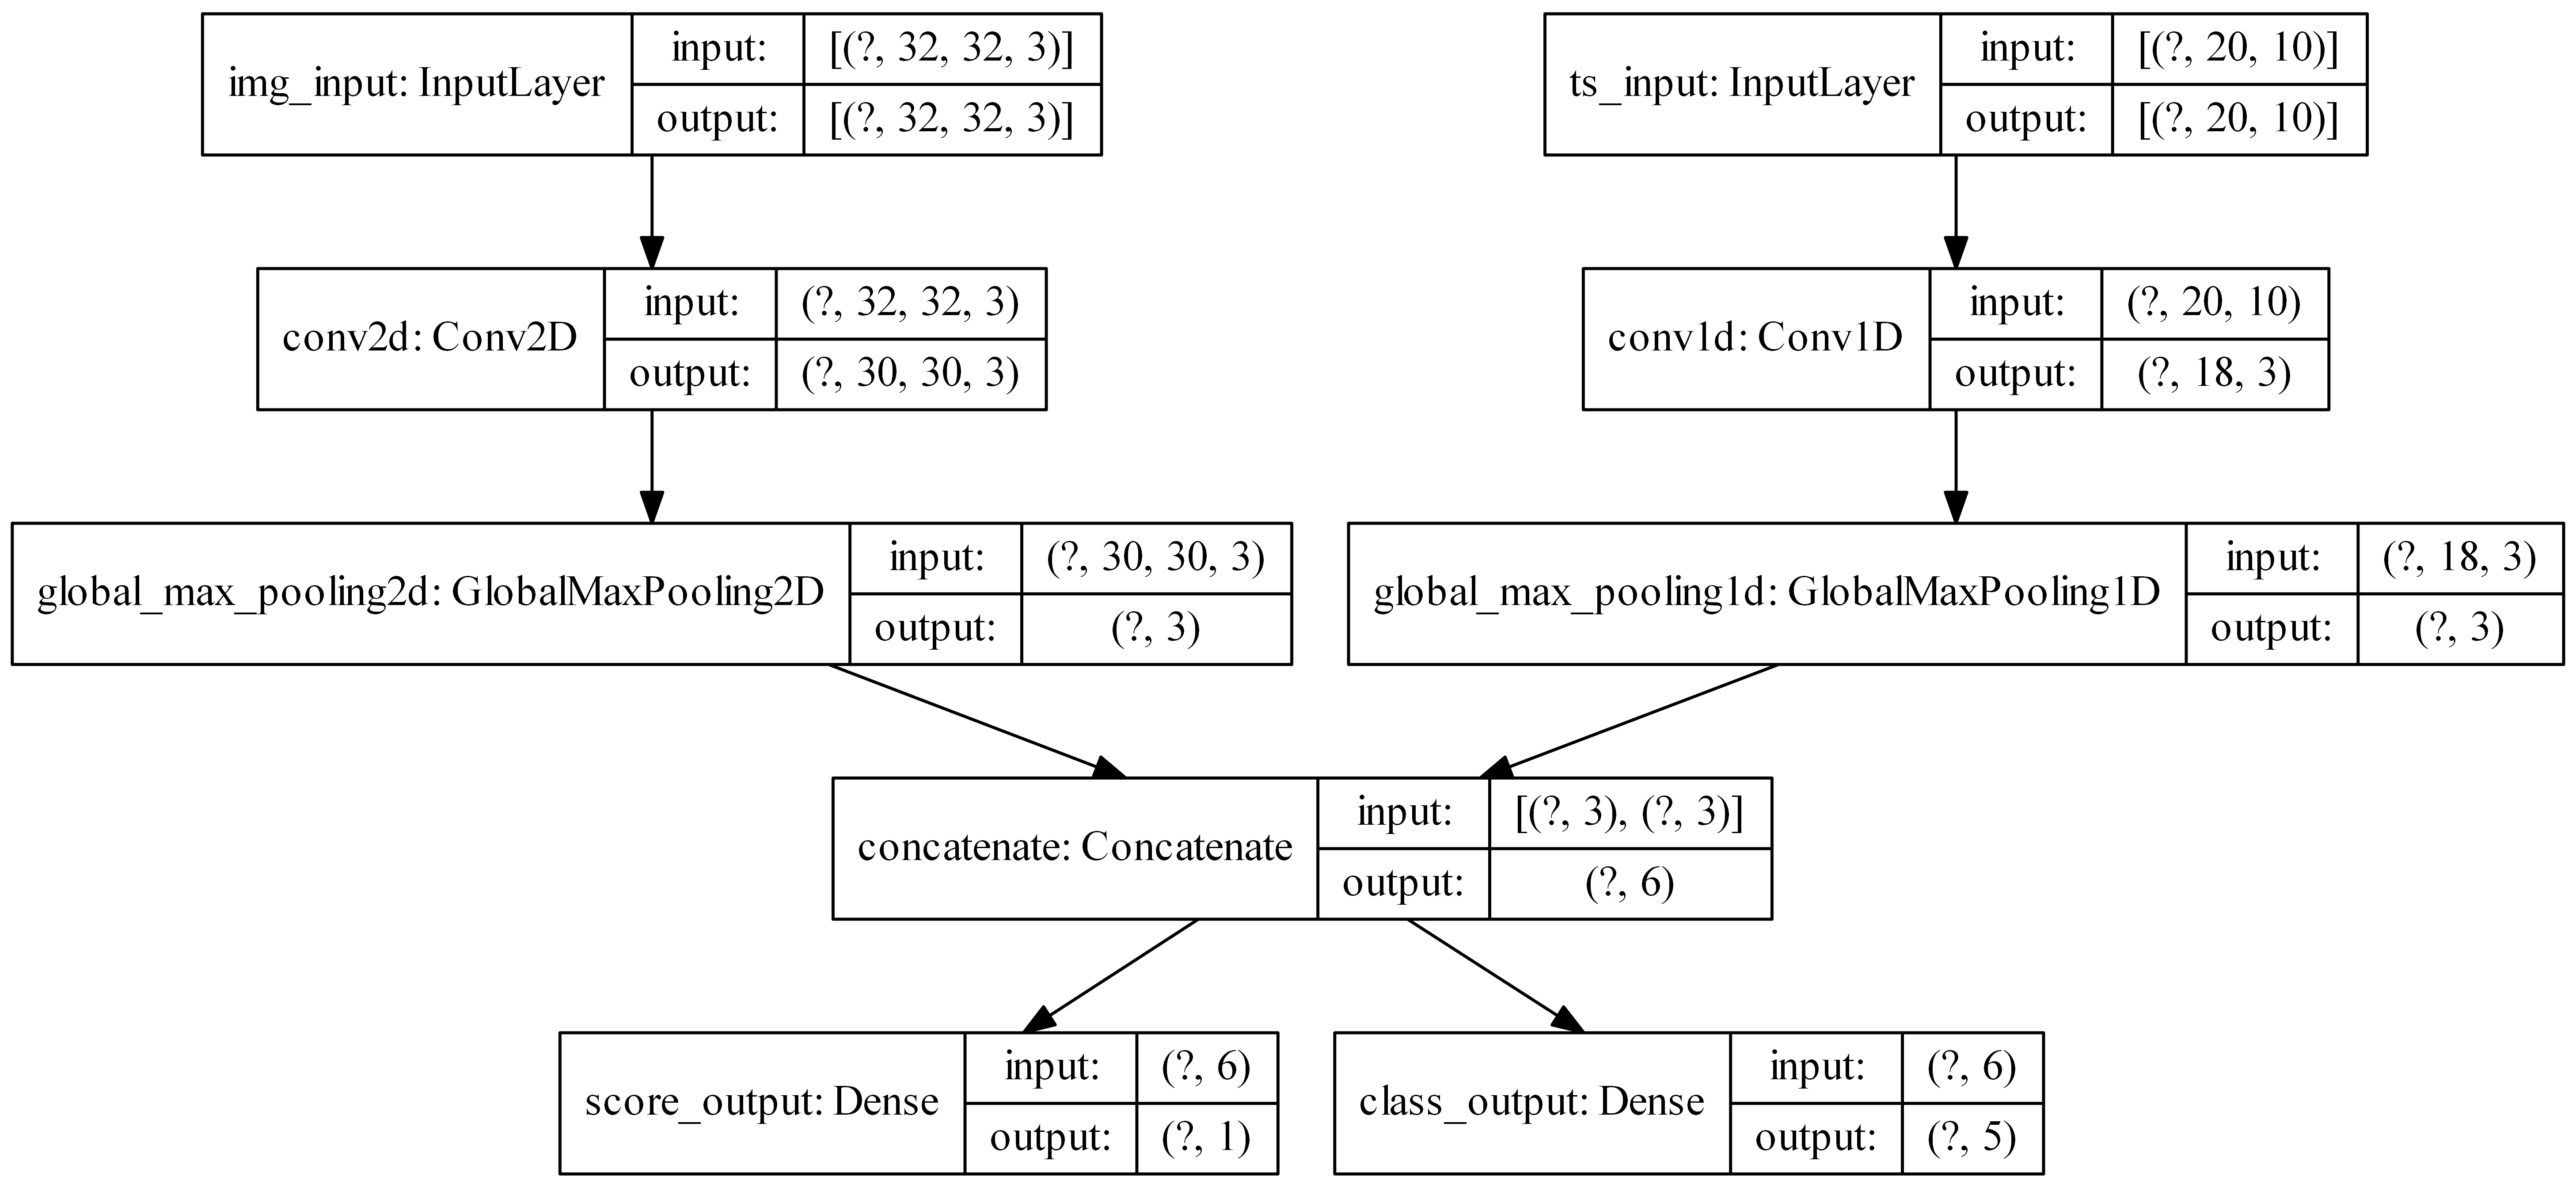

In [33]:
#https://blog.csdn.net/weixin_42459037/article/details/84066164

tf.keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True,dpi=500)

### 4.1 损失函数
在编译时，通过将损失函数作为列表传递，我们可以为不同的输出指定不同的损失：

In [34]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(1e-3),
    loss=[tf.keras.losses.MeanSquaredError(),
          tf.keras.losses.CategoricalCrossentropy(from_logits=True)])

如果我们仅将单个损失函数传递给模型，则将相同的损失函数应用于每个输出，这在此处不合适。

### 4.2指标函数
同样对于指标：


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(1e-3),
    loss=[tf.keras.losses.MeanSquaredError(),
          tf.keras.losses.CategoricalCrossentropy(from_logits=True)],
    metrics=[
        [tf.keras.metrics.MeanAbsolutePercentageError(),
              tf.keras.metrics.MeanAbsoluteError()],
        
             [tf.keras.metrics.CategoricalAccuracy()]
    ]

)

由于我们为输出层命名，因此我们还可以通过dict指定每个输出的损失和指标：

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(1e-3),
    loss={'score_output': tf.keras.losses.MeanSquaredError(),
          'class_output': tf.keras.losses.CategoricalCrossentropy(from_logits=True)
         },
    metrics={'score_output': [tf.keras.metrics.MeanAbsolutePercentageError(),
                              tf.keras.metrics.MeanAbsoluteError()],
             
             'class_output': [tf.keras.metrics.CategoricalAccuracy()]}
)

如果您有两个以上的输出，我们建议使用显式名称和字典。

可以使用以下参数对不同的特定于输出的损失赋予不同的权重（例如，在我们的示例中，我们可能希望通过将某类损失函数赋予更高的权重）

loss_weights：

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(1e-3),
    loss={'score_output': tf.keras.losses.MeanSquaredError(),
          'class_output': tf.keras.losses.CategoricalCrossentropy(from_logits=True)},
    metrics={'score_output': [tf.keras.metrics.MeanAbsolutePercentageError(),
                              tf.keras.metrics.MeanAbsoluteError()],
             'class_output': [tf.keras.metrics.CategoricalAccuracy()]},
    loss_weights={'score_output': 2., 'class_output': 1.})

您还可以选择不为某些输出计算损失，如果这些输出仅用于预测而不是训练：

In [ ]:
# List loss version
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(1e-3),
    loss=[None, tf.keras.losses.CategoricalCrossentropy(from_logits=True)])

# Or dict loss version
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(1e-3),
    loss={'class_output':tf.keras.losses.CategoricalCrossentropy(from_logits=True)})

### 4.3完整运行

In [35]:


image_input = tf.keras.Input(shape=(32, 32, 3), name='img_input')
timeseries_input = tf.keras.Input(shape=(20, 10), name='ts_input')

x1 = tf.keras.layers.Conv2D(3, 3)(image_input)
x1 = tf.keras.layers.GlobalMaxPooling2D()(x1)


x2 = tf.keras.layers.Conv1D(3, 3)(timeseries_input)
x2 = tf.keras.layers.GlobalMaxPooling1D()(x2)

x = tf.keras.layers.concatenate([x1, x2])

score_output = tf.keras.layers.Dense(1, name='score_output')(x)
class_output = tf.keras.layers.Dense(5, name='class_output')(x)

model = tf.keras.Model(inputs=[image_input, timeseries_input],
                    outputs=[score_output, class_output])

In [36]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(1e-3),
    loss=[tf.keras.losses.MeanSquaredError(),
          tf.keras.losses.CategoricalCrossentropy(from_logits=True)])

# Generate dummy Numpy data
import numpy as np
img_data = np.random.random_sample(size=(100, 32, 32, 3))
ts_data = np.random.random_sample(size=(100, 20, 10))
score_targets = np.random.random_sample(size=(100, 1))
class_targets = np.random.random_sample(size=(100, 5))

# Fit on lists
model.fit([img_data, ts_data], [score_targets, class_targets],
          batch_size=32,
          epochs=3)

# Alternatively, fit on dicts
model.fit({'img_input': img_data, 'ts_input': ts_data},
          {'score_output': score_targets, 'class_output': class_targets},
          batch_size=32,
          epochs=3)

Train on 100 samples
Epoch 1/3
100/100 [==============================] - 3s 26ms/sample - loss: 4.6500 - score_output_loss: 0.0963 - class_output_loss: 4.6443
Epoch 2/3
100/100 [==============================] - 0s 400us/sample - loss: 4.5148 - score_output_loss: 0.0766 - class_output_loss: 4.6994
Epoch 3/3
100/100 [==============================] - 0s 900us/sample - loss: 4.4384 - score_output_loss: 0.0813 - class_output_loss: 4.6595
Train on 100 samples
Epoch 1/3
100/100 [==============================] - 0s 800us/sample - loss: 4.4204 - score_output_loss: 0.0807 - class_output_loss: 4.2080
Epoch 2/3
100/100 [==============================] - 0s 800us/sample - loss: 4.4159 - score_output_loss: 0.0945 - class_output_loss: 4.3787
Epoch 3/3
100/100 [==============================] - 0s 300us/sample - loss: 4.4291 - score_output_loss: 0.1037 - class_output_loss: 4.3664


In [38]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(1e-3),
    loss=[tf.keras.losses.MeanSquaredError(),
          tf.keras.losses.CategoricalCrossentropy(from_logits=True)])

# Generate dummy Numpy data
import numpy as np
img_data = np.random.random_sample(size=(100, 32, 32, 3))
ts_data = np.random.random_sample(size=(100, 20, 10))
score_targets = np.random.random_sample(size=(100, 1))
class_targets = np.random.random_sample(size=(100, 5))



# Alternatively, fit on dicts
model.fit((img_data,  ts_data),
          (score_targets, class_targets),
          batch_size=32,
          epochs=3)

Train on 100 samples
Epoch 1/3
100/100 [==============================] - 1s 11ms/sample - loss: 4.8652 - score_output_loss: 0.1548 - class_output_loss: 4.8238
Epoch 2/3
100/100 [==============================] - 0s 300us/sample - loss: 4.9714 - score_output_loss: 0.1119 - class_output_loss: 5.0570
Epoch 3/3
100/100 [==============================] - 0s 545us/sample - loss: 5.0455 - score_output_loss: 0.1024 - class_output_loss: 4.6104
